In [42]:
pip install numpy pandas scikit-learn matplotlib tensorflow


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from collections import deque

In [12]:
# Load the data
df = pd.read_csv('dataResearch.csv', usecols=lambda column: column not in ['SL.', 'Station', 'Year', 'Month', 'Temperature (maximum)', 'Temperature(Average)', 'Temperature(minimum)', 'Humidity(percentage)'])
df

,Date,Rainfall(mm)
0,1/1/1970,62
1,1/2/1970,65
2,1/3/1970,60
3,1/4/1970,466
4,1/5/1970,851
...,...,...
631,1/8/2022,461
632,1/9/2022,744
633,1/10/2022,334
634,1/11/2022,0


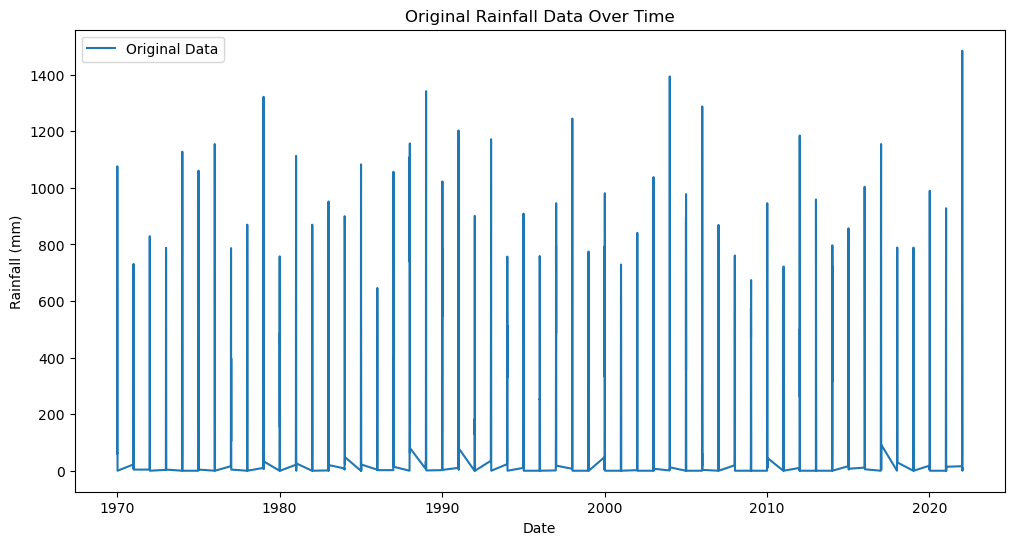

In [44]:
# Preprocess the data
df['Date'] = pd.to_datetime(df['Date'])
df['Rainfall(mm)'] = pd.to_numeric(df['Rainfall(mm)'], errors='coerce')
df.sort_values(by='Date', inplace=True)

# Visualize the original data
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Rainfall(mm)'], label='Original Data')
plt.title('Original Rainfall Data Over Time')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.legend()
plt.show()


In [45]:
# Prepare the data for training
X_train = df['Rainfall(mm)'].values.reshape(-1, 1)

# Scale the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Function to create sequences for LSTM
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i+sequence_length]
        sequences.append(seq)
    return np.array(sequences)

# Create sequences for training
sequence_length = 12
X_train_sequences = create_sequences(X_train_scaled, sequence_length)


In [46]:
# Split into input and target
X_train_input = X_train_sequences[:, :-1]
y_train_target = X_train_sequences[:, -1]

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train_input.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train_input, y_train_target, epochs=50, batch_size=32)


Epoch 1/50
20/20 [==============================] - 2s 5ms/step - loss: 0.0786
Epoch 2/50
20/20 [==============================] - 0s 4ms/step - loss: 0.0542
Epoch 3/50
20/20 [==============================] - 0s 4ms/step - loss: 0.0492
Epoch 4/50
20/20 [==============================] - 0s 4ms/step - loss: 0.0447
Epoch 5/50
20/20 [==============================] - 0s 5ms/step - loss: 0.0386
Epoch 6/50
20/20 [==============================] - 0s 5ms/step - loss: 0.0297
Epoch 7/50
20/20 [==============================] - 0s 5ms/step - loss: 0.0201
Epoch 8/50
20/20 [==============================] - 0s 4ms/step - loss: 0.0196
Epoch 9/50
20/20 [==============================] - 0s 4ms/step - loss: 0.0181
Epoch 10/50
20/20 [==============================] - 0s 5ms/step - loss: 0.0188
Epoch 11/50
20/20 [==============================] - 0s 4ms/step - loss: 0.0166
Epoch 12/50
20/20 [==============================] - 0s 3ms/step - loss: 0.0168
Epoch 13/50
20/20 [==============================

In [51]:
# Predict the next 24 months
future_seq = deque(X_train_scaled[-sequence_length:].tolist(), maxlen=sequence_length)
predictions = []

for _ in range(24):
    # Use the last 11 elements of future_seq to match the training sequence length
    future_seq_array = np.array(list(future_seq)[-11:]).reshape(1, sequence_length - 1, 1)
    prediction = model.predict(future_seq_array)[0, 0]
    predictions.append(prediction)
    future_seq.append([prediction])



# Inverse transform the predicted values
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))


1/1 [==============================] - 0s 19ms/step


In [53]:
# Create a DataFrame for the predicted values with corresponding dates
last_date = df['Date'].max()
date_range = pd.date_range(start=last_date + pd.DateOffset(1), periods=24, freq='M')
predicted_df = pd.DataFrame({'Date': date_range, 'Predicted_Rainfall(mm)': predictions.flatten()})
predicted_df

,Date,Predicted_Rainfall(mm)
0,2022-01-31,-47.182285
1,2022-02-28,-13.895267
2,2022-03-31,118.017700
3,2022-04-30,340.216766
4,2022-05-31,569.696594
5,2022-06-30,753.329895
6,2022-07-31,800.198181
7,2022-08-31,745.601501
8,2022-09-30,530.739502
9,2022-10-31,305.284424


In [63]:
df.tail(10)

,Date,Rainfall(mm)
626,2022-01-03,79
627,2022-01-04,287
628,2022-01-05,902
629,2022-01-06,1485
630,2022-01-07,778
631,2022-01-08,461
632,2022-01-09,744
633,2022-01-10,334
634,2022-01-11,0
635,2022-01-12,8


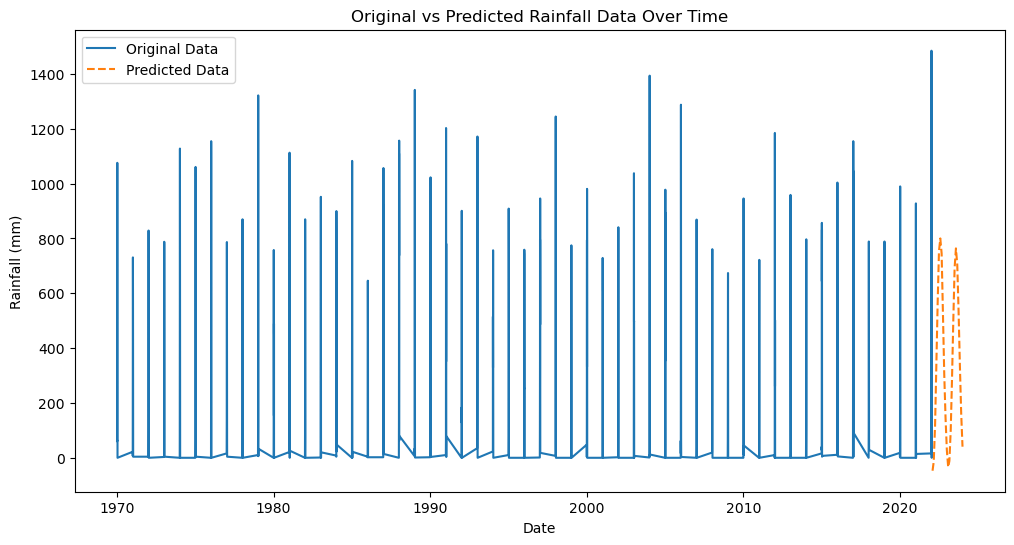

In [54]:
import matplotlib.pyplot as plt

# Assuming df is your original DataFrame and predicted_df contains the predicted values
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Rainfall(mm)'], label='Original Data')
plt.plot(predicted_df['Date'], predicted_df['Predicted_Rainfall(mm)'], label='Predicted Data', linestyle='dashed')
plt.title('Original vs Predicted Rainfall Data Over Time')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.legend()
plt.show()


In [61]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score

# Assuming df_test contains the actual test data
# Assuming predicted_df contains the predicted data

# Merge the actual test data and predicted data on the 'Date' column
merged_df = pd.merge(df_test, predicted_df, on='Date', how='inner', suffixes=('_actual', '_predicted'))

# Calculate performance metrics
mse = mean_squared_error(merged_df['Rainfall(mm)_actual'], merged_df['Predicted_Rainfall(mm)'])
mae = mean_absolute_error(merged_df['Rainfall(mm)_actual'], merged_df['Predicted_Rainfall(mm)'])
rmse = np.sqrt(mse)
evs = explained_variance_score(merged_df['Rainfall(mm)_actual'], merged_df['Predicted_Rainfall(mm)'])

print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'Explained Variance Score: {evs:.2f}')


NameError: name 'df_test' is not defined

In [13]:
# Assuming your DataFrame is named df
df['Date'] = pd.to_datetime(df['Date'])
df['Rainfall(mm)'] = pd.to_numeric(df['Rainfall(mm)'], errors='coerce')
df.sort_values(by='Date', inplace=True)


Text(0.5, 0, 'parameters')

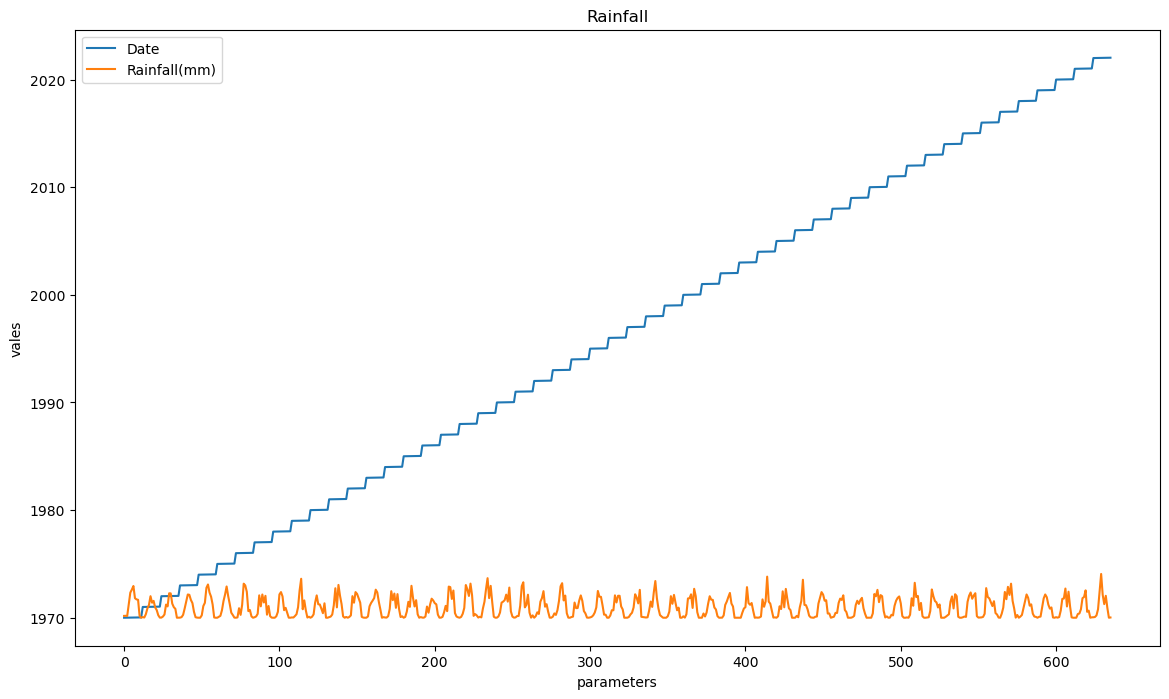

In [14]:
df.plot(kind='line',figsize=(14,8))
plt.title('Rainfall')
plt.ylabel('vales')
plt.xlabel('parameters')

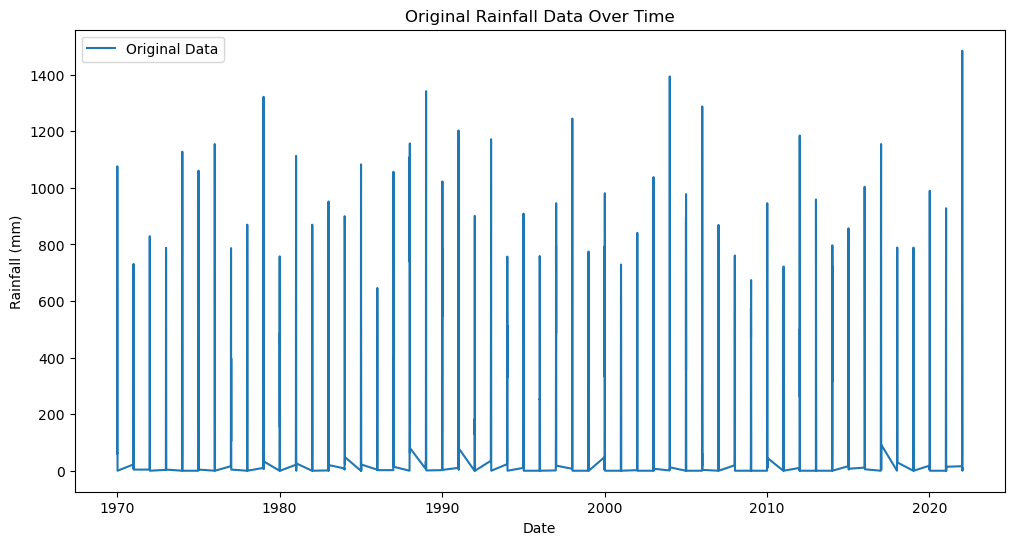

In [15]:
# Visualize the original data
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Rainfall(mm)'], label='Original Data')
plt.title('Original Rainfall Data Over Time')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.legend()
plt.show()


In [21]:
# Prepare the data for training
X_train = df['Rainfall(mm)'].values.reshape(-1, 1)

# Scale the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)


In [25]:

import torch.optim as optim

# Assuming your sequence length is 12 and you're predicting the next value
sequence_length = 12
input_size = 1  # Assuming you have one feature (Rainfall(mm))

# Define your loss function
criterion = nn.MSELoss()

# Define your optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Assuming you have a PyTorch model class named SimpleModel
class SimpleModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleModel, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

In [27]:
# Instantiate your model
input_size = 1
hidden_size = 64
output_size = 1
model = SimpleModel(input_size, hidden_size, output_size)

# Define your loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [28]:
# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    inputs = torch.FloatTensor(X_train_scaled[:-1]).reshape(1, -1, 1)
    targets = torch.FloatTensor(X_train_scaled[1:]).reshape(1, -1, 1)

    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')


C:\ProgramData\anaconda3\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([1, 635, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 0.07942347228527069
Epoch [20/100], Loss: 0.05507192388176918
Epoch [30/100], Loss: 0.052438680082559586
Epoch [40/100], Loss: 0.05314940959215164
Epoch [50/100], Loss: 0.052461862564086914
Epoch [60/100], Loss: 0.052482929080724716
Epoch [70/100], Loss: 0.05246483534574509
Epoch [80/100], Loss: 0.05243581905961037
Epoch [90/100], Loss: 0.05243831127882004
Epoch [100/100], Loss: 0.05243717133998871


In [29]:
# Save the trained model weights
torch.save(model.state_dict(), 'my_model_weights.pth')
print("Model weights saved.")

Model weights saved.


In [30]:
# Load the saved model weights
model = SimpleModel(input_size, hidden_size, output_size)
model.load_state_dict(torch.load('my_model_weights.pth'))
model.eval()


SimpleModel(
  (rnn): LSTM(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [31]:
# Predict the next 24 months
sequence_length = 12
future_seq = deque(X_train_scaled[-sequence_length:].tolist(), maxlen=sequence_length)
predictions = []

with torch.no_grad():
    for _ in range(24):
        future_seq_tensor = torch.FloatTensor(np.array(future_seq).reshape(1, sequence_length, 1))
        prediction = model(future_seq_tensor).item()
        predictions.append(prediction)
        future_seq.append([prediction])


In [32]:
# Inverse transform the predicted values
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))


In [36]:
df.tail(12)

,Date,Rainfall(mm)
624,2022-01-01,16
625,2022-01-02,24
626,2022-01-03,79
627,2022-01-04,287
628,2022-01-05,902
629,2022-01-06,1485
630,2022-01-07,778
631,2022-01-08,461
632,2022-01-09,744
633,2022-01-10,334


In [35]:
# Create a DataFrame for the predicted values with corresponding dates
last_date = df['Date'].max()
date_range = pd.date_range(start=last_date + pd.DateOffset(1), periods=24, freq='M')
predicted_df = pd.DataFrame({'Date': date_range, 'Predicted_Rainfall(mm)': predictions.flatten()})
predicted_df 

,Date,Predicted_Rainfall(mm)
0,2022-01-31,329.144990
1,2022-02-28,326.108577
2,2022-03-31,325.501113
3,2022-04-30,325.759615
4,2022-05-31,326.291887
5,2022-06-30,326.792428
6,2022-07-31,327.190802
7,2022-08-31,327.606968
8,2022-09-30,327.939754
9,2022-10-31,328.136695


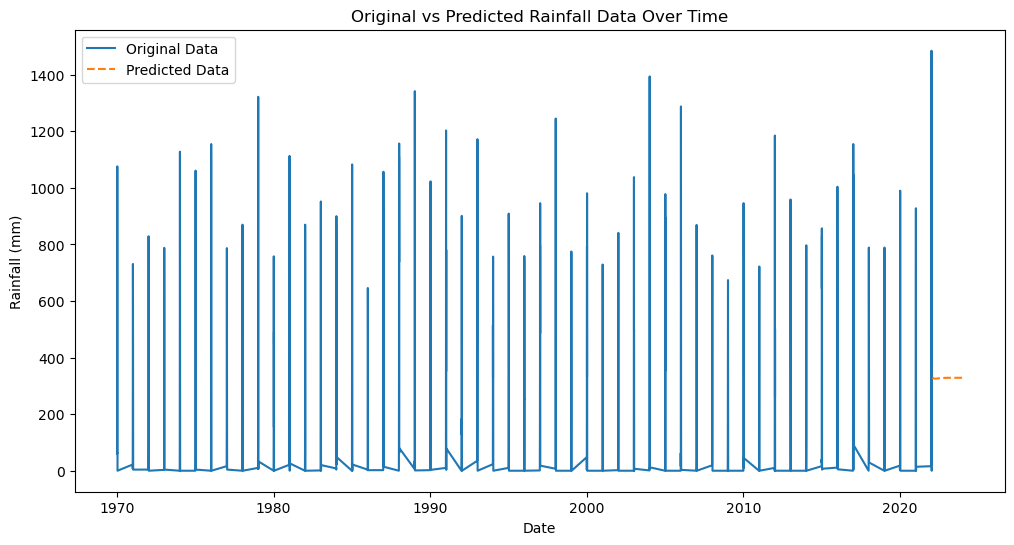

In [34]:
# Visualize the original data and predictions
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Rainfall(mm)'], label='Original Data')
plt.plot(predicted_df['Date'], predicted_df['Predicted_Rainfall(mm)'], label='Predicted Data', linestyle='dashed')
plt.title('Original vs Predicted Rainfall Data Over Time')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.legend()
plt.show()

<Axes: >

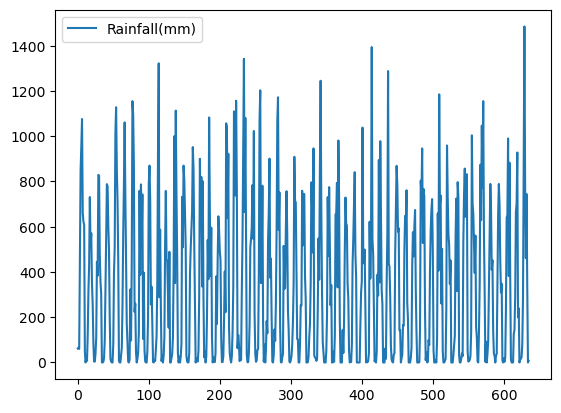

In [8]:
training_df=df[cols].astype(float)
plot_df=training_df
plot_df.plot.line()

In [9]:
from sklearn.preprocessing import StandardScaler
scalar=StandardScaler()
scalar=scalar.fit(training_df)
training_df_scaled=scalar.transform(training_df)

In [10]:
#Lists for storing the training data considering multiple variables
#trainX for storing training data (temperature,wind speed,relative humidity)
#trainY for storing target values(rainfall)
trainX=[] 
trainY=[]

n_past=20#20 values will be considered to predict the next values
n_fut=100#for predicting the next 100 value based on previous 20 values


#Adding the values to trainX and trainY lists
for i in range(n_past,len(training_df_scaled)-n_fut+1):
    trainX.append(training_df_scaled[i-n_past:i,0:training_df_scaled.shape[1]])
    trainY.append(training_df_scaled[i+n_fut-1:i+n_fut,0])

#Converting into numpy arrays
trainX,trainY=np.array(trainX),np.array(trainY)

print('trainX shape == {}'.format(trainX.shape))#Knowing the shape 
#(364,20,4) means there are 364windows(groups) of 20*4


print('trainY shape == {}'.format(trainY.shape))
#There are 364 values from previous values

trainX shape == (517, 20, 1)
trainY shape == (517, 1)


In [11]:
model=Sequential()
model.add(LSTM(32,activation='relu',input_shape=(trainX.shape[1],trainX.shape[2]),return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(32,activation='relu',return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(32,activation='relu',return_sequences=False))
model.add(Dropout(0.3))

model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam',loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 32)            4352      
                                                                 
 dropout (Dropout)           (None, 20, 32)            0         
                                                                 
 lstm_1 (LSTM)               (None, 20, 32)            8320      
                                                                 
 dropout_1 (Dropout)         (None, 20, 32)            0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 3

In [12]:
history=model.fit(trainX,trainY,epochs=30,batch_size=5,validation_split=0.2,verbose=1)

Epoch 1/30
83/83 [==============================] - 6s 22ms/step - loss: 0.9824 - val_loss: 1.0506
Epoch 2/30
83/83 [==============================] - 1s 13ms/step - loss: 0.9723 - val_loss: 1.0326
Epoch 3/30
83/83 [==============================] - 1s 14ms/step - loss: 0.8375 - val_loss: 0.5175
Epoch 4/30
83/83 [==============================] - 1s 14ms/step - loss: 0.5119 - val_loss: 0.4203
Epoch 5/30
83/83 [==============================] - 1s 13ms/step - loss: 0.4968 - val_loss: 0.3705
Epoch 6/30
83/83 [==============================] - 1s 13ms/step - loss: 0.3786 - val_loss: 0.3607
Epoch 7/30
83/83 [==============================] - 1s 12ms/step - loss: 0.3824 - val_loss: 0.4299
Epoch 8/30
83/83 [==============================] - 1s 12ms/step - loss: 0.3805 - val_loss: 0.3418
Epoch 9/30
83/83 [==============================] - 1s 13ms/step - loss: 0.3929 - val_loss: 0.3396
Epoch 10/30
83/83 [==============================] - 1s 14ms/step - loss: 0.3575 - val_loss: 0.3465
Epoch 11/

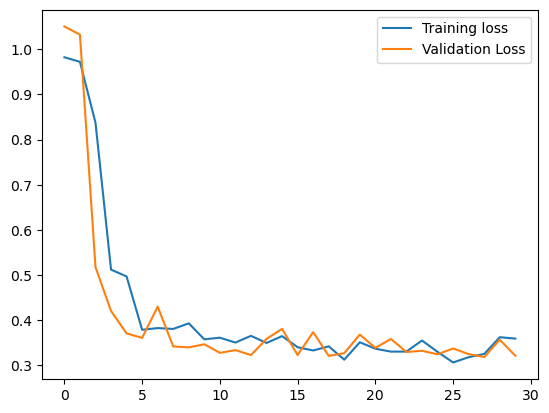

In [13]:
plt.plot(history.history['loss'],label='Training loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend()

In [14]:
#Predicting...
#Libraries that will help us extract only business days in the US.
#Otherwise our dates would be wrong when we look back (or forward).  
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

n_past = 1
n_days_for_prediction=100  

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()

# make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

#Perform inverse transformation to rescale back to original range
#Since we used 1 variables for transform, the inverse expects same dimensions
prediction_copies = np.repeat(prediction, training_df.shape[1], axis=-1)

y_pred_future = scalar.inverse_transform(prediction_copies)[:,0]

# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Rainfall(mm)':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

4/4 [==============================] - 1s 4ms/step


In [15]:
#import seaborn as sns

#original = df[['Date', 'Rainfall(mm)']]
#original['Date']=pd.to_datetime(original['Date'])
#original = original.loc[original['Date'] >= '2017-1-1']

#sns.set(rc = {'figure.figsize':(15,8)})
#sns.lineplot(original['Date'], original['Rainfall(mm)'])
#sns.lineplot(df_forecast['Date'], df_forecast['Rainfall(mm)'])#

import pandas as pd
import seaborn as sns

# Assuming 'original' is your DataFrame
original['Date'] = pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2017-01-01']

sns.set(rc={'figure.figsize': (12, 8)})

# Use the data, x, and y parameters to specify the DataFrame and columns
sns.lineplot(data=original, x='Date', y='Rainfall(mm)')


NameError: name 'original' is not defined

In [ ]:
print(df_forecast['Date'].min())
print(df_forecast['Date'].max())


In [ ]:
import pandas as pd

# Assuming 'original' is your DataFrame
original['Date'] = pd.to_datetime(original['Date'])

# Filter the original dataset for the specified time range
forecast_period_data = original.loc[(original['Date'] >= '2022-01-12') & (original['Date'] <= '2022-06-03')]

# Display the relevant columns of the filtered data
print(forecast_period_data[['Date', 'Rainfall(mm)']])